# build dataset

In [1]:
import seismic_dataset_builder
    
#noisers = [None, seismic_handler.FreqNoiser()]
noisers = [None,                                                # original gather
           seismic_dataset_builder.BP(0.1, 0.15, 0.2, 0.25, 1), # BP1
           seismic_dataset_builder.BP(0.2, 0.25, 0.3, 0.35, 1), # BP2
           seismic_dataset_builder.BP(0.3, 0.35, 0.4, 0.45, 1), # BP3
           seismic_dataset_builder.BP(0.4, 0.45, 0.5, 0.55, 1), # BP4
          ]
#noisers = [None, seismic_handler.BP(0.1, 0.15, 0.2, 0.25, 1)]

(X_train, y_train), (X_test, y_test) = seismic_dataset_builder.create_seis_dataset ( file_name ='data/prestack.sgy', 
                                                                                     sorting_key = 'original_field_record_number', 
                                                                                     window = [50, 0.5], 
                                                                                     noisers = noisers,
                                                                                     #images_dir = None # dont create images
                                                                                    )

Using TensorFlow backend.


# build and train CNN

In [2]:
import seismic_ml_kernel
#seismic_ml_kernel.mn (X_train[0], y_train, X_test[0], y_test)
model = seismic_ml_kernel.ci_multi_train (X_train, y_train, 30)

image has 4600 pixels


C:\Users\kostyad\Documents\Jupyter\seismic_fingerprint\seismic_ml_kernel.py:138: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  vision_model = Model(input=inp, output=flat) # To define a model, just specify its input and output layers


image has 2300 pixels
image has 2350 pixels
number of vision models 3
Vision models are ready
Classification model is ready
Classification model compiled
Train on 11907 samples, validate on 1324 samples
Epoch 1/30
11907/11907 [==============================] - 819s - loss: 1.3420 - acc: 0.4175 - val_loss: 0.7045 - val_acc: 0.8006
Epoch 2/30
11907/11907 [==============================] - 857s - loss: 0.8795 - acc: 0.6690 - val_loss: 0.5360 - val_acc: 0.8580
Epoch 3/30
11907/11907 [==============================] - 854s - loss: 0.7626 - acc: 0.7182 - val_loss: 0.4593 - val_acc: 0.8542
Epoch 4/30
11907/11907 [==============================] - 854s - loss: 0.7143 - acc: 0.7402 - val_loss: 0.3964 - val_acc: 0.8852
Epoch 5/30
11907/11907 [==============================] - 851s - loss: 0.6709 - acc: 0.7530 - val_loss: 0.3682 - val_acc: 0.8988
Epoch 6/30
11907/11907 [==============================] - 829s - loss: 0.6242 - acc: 0.7677 - val_loss: 0.3492 - val_acc: 0.8814
Epoch 7/30
11907/11907 

# test dataset

In [3]:
seismic_ml_kernel.ci_multi_test (model, X_test, y_test)

3214/3214 [==============================] - 62s    
[0.35144880864660266, 0.87834474179191324]


# prediction on single image

sample 2474
correct 1


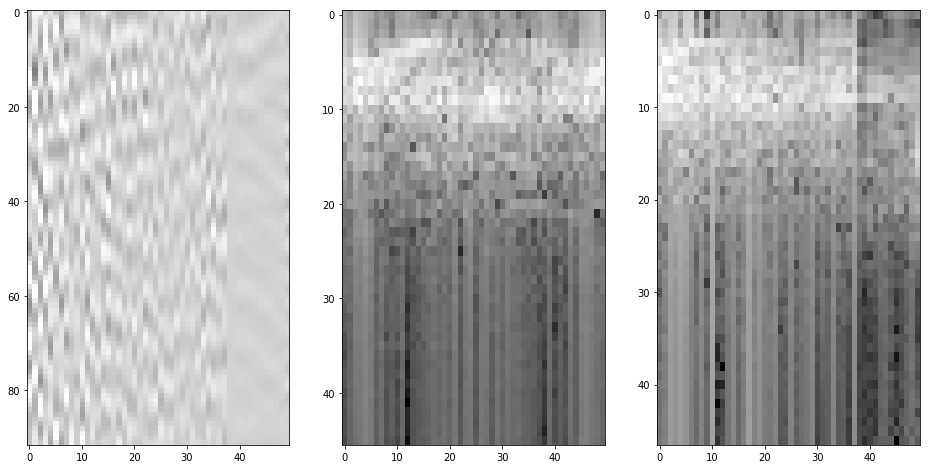

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
    
sample, correct, table = seismic_ml_kernel.ci_multi_evaluate_random (model, X_test, y_test)

print('sample', sample)
print('correct', correct)

table

# vision model 1
![title](outputs/vision_model0.png)

# vision model 2
![title](outputs/vision_model1.png)

# vision model 3
![title](outputs/vision_model2.png)

# classification model
![title](outputs/classification_model.png)

In [ ]:
python -m tensorflow.tensorboard --logdir=outputs/Graph

In [ ]:
import h5py
import json
import gzip

layer_name_dict = {
    'Dense': 'denseLayer',
    'Dropout': 'dropoutLayer',
    'Flatten': 'flattenLayer',
    'Embedding': 'embeddingLayer',
    'BatchNormalization': 'batchNormalizationLayer',
    'LeakyReLU': 'leakyReLULayer',
    'PReLU': 'parametricReLULayer',
    'ParametricSoftplus': 'parametricSoftplusLayer',
    'ThresholdedLinear': 'thresholdedLinearLayer',
    'ThresholdedReLu': 'thresholdedReLuLayer',
    'LSTM': 'rLSTMLayer',
    'GRU': 'rGRULayer',
    'JZS1': 'rJZS1Layer',
    'JZS2': 'rJZS2Layer',
    'JZS3': 'rJZS3Layer',
    'Convolution2D': 'convolution2DLayer',
    'MaxPooling2D': 'maxPooling2DLayer'
}

layer_params_dict = {
    'Dense': ['weights', 'activation'],
    'Dropout': ['p'],
    'Flatten': [],
    'Embedding': ['weights'],
    'BatchNormalization': ['weights', 'epsilon'],
    'LeakyReLU': ['alpha'],
    'PReLU': ['weights'],
    'ParametricSoftplus': ['weights'],
    'ThresholdedLinear': ['theta'],
    'ThresholdedReLu': ['theta'],
    'LSTM': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'GRU': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS1': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS2': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'JZS3': ['weights', 'activation', 'inner_activation', 'return_sequences'],
    'Convolution2D': ['weights', 'nb_filter', 'nb_row', 'nb_col', 'border_mode', 'subsample', 'activation'],
    'MaxPooling2D': ['pool_size', 'stride', 'ignore_border']
}

layer_weights_dict = {
    'Dense': ['W', 'b'],
    'Embedding': ['E'],
    'BatchNormalization': ['gamma', 'beta', 'mean', 'std'],
    'PReLU': ['alphas'],
    'ParametricSoftplus': ['alphas', 'betas'],
    'LSTM': ['W_xi', 'W_hi', 'b_i', 'W_xc', 'W_hc', 'b_c', 'W_xf', 'W_hf', 'b_f', 'W_xo', 'W_ho', 'b_o'],
    'GRU': ['W_xz', 'W_hz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h'],
    'JZS1': ['W_xz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_hh', 'b_h', 'Pmat'],
    'JZS2': ['W_xz', 'W_hz', 'b_z', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h', 'Pmat'],
    'JZS3': ['W_xz', 'W_hz', 'b_z', 'W_xr', 'W_hr', 'b_r', 'W_xh', 'W_hh', 'b_h'],
    'Convolution2D': ['W', 'b']
}

def serialize(model_json_file, weights_hdf5_file, save_filepath, compress):
    with open(model_json_file, 'r') as f:
        model_metadata = json.load(f)
    weights_file = h5py.File(weights_hdf5_file, 'r')

    layers = []

    num_activation_layers = 0
    for k, layer in enumerate(model_metadata['layers']):
        if layer['name'] == 'Activation':
            num_activation_layers += 1
            prev_layer_name = model_metadata['layers'][k-1]['name']
            idx_activation = layer_params_dict[prev_layer_name].index('activation')
            layers[k-num_activation_layers]['parameters'][idx_activation] = layer['activation']
            continue

        layer_params = []

        for param in layer_params_dict[layer['name']]:
            if param == 'weights':
                layer_weights = list(weights_file.get('layer_{}'.format(k)))
                weights = {}
                weight_names = layer_weights_dict[layer['name']]
                for name, w in zip(weight_names, layer_weights):
                    weights[name] = weights_file.get('layer_{}/{}'.format(k, w)).value.tolist()
                layer_params.append(weights)
            else:
                layer_params.append(layer[param])

        layers.append({
            'layerName': layer_name_dict[layer['name']],
            'parameters': layer_params
        })

    if compress:
        with gzip.open(save_filepath, 'wb') as f:
            f.write(json.dumps(layers).encode('utf8'))
    else:
        with open(save_filepath, 'w') as f:
            json.dump(layers, f)


In [ ]:
import json
model_metadata = json.loads(model.to_json())

with open('web_interface/model.json', 'w') as f:
    json.dump(model_metadata, f)
    
model.save_weights('web_interface/weights.hdf5')

In [ ]:
serialize('web_interface/model.json', 
          'web_interface/model.hdf5', 
          'web_interface/model_params.json.gz', 
          True)

In [ ]:
X_save = [a.tolist() for a in X_test]
with gzip.open('web_interface/data.json.gz', 'wb') as f:
    f.write(json.dumps({'data': X_save, 'labels': y_test.tolist()}).encode('utf8'))
#with open('sample_data.json', 'w') as f:
#    json.dump({'data': X_rand.tolist(), 'labels': y_rand.tolist()}, f)

In [ ]:
import encoder
e = Encoder ('web_interface/model.hdf5')
e.serialize()
e.save()